## PG_modeling_LR_RF_noneng_only-baseline.ipynb

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import auc, roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import scale

In [2]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import descartes
import sys
import sklearn
from shapely.ops import nearest_points
from datetime import datetime as dt, date
sys.path.append('/Users/pedrogalarza/Documents/NYU-MSDS/2020_fall/DSGA-1001/Project-Wildfire/wildfires-1001/code/functions')
from gis_processing import *
from modeling_functions import *
import pickle

## Data Import
### county grid

In [3]:
project_dir = '/Users/pedrogalarza/Documents/NYU-MSDS/2020_fall/DSGA-1001/Project-Wildfire/wildfires-1001/'
data_dir = os.path.join(project_dir, "data")

In [4]:
#CA grid map
county_grid_path = os.path.join(data_dir, 'clean_data/county_grid/county_grid.shp')
county_grid_gdf = gpd.read_file(county_grid_path)
county_grid_gdf.head()

,NAME,COUNTYFP,GEOID,ALAND,AWATER,COUNTY_ARE,GRID_AREA,GRID_ID,COUNTY_GRI,COUNTY_G_1,geometry
0,Plumas,063,06063,6612400993,156387635,1.155000e+10,5.041000e+09,49.0,4.936293e+09,0.427385,"POLYGON ((-13502275.000 4897930.000, -13431275..."
1,Sierra,091,06091,2468694587,23299110,4.200450e+09,5.041000e+09,50.0,1.535563e+09,0.365571,"POLYGON ((-13502275.000 4826930.000, -13431275..."
2,Sierra,091,06091,2468694587,23299110,4.200450e+09,5.041000e+09,65.0,2.544187e+09,0.605694,"POLYGON ((-13431275.000 4826930.000, -13360275..."
3,Sacramento,067,06067,2499183617,76073827,4.205267e+09,5.041000e+09,39.0,2.029400e+09,0.482585,"POLYGON ((-13573275.000 4684930.000, -13502275..."
4,Contra Costa,013,06013,1871930816,209819213,3.351027e+09,5.041000e+09,40.0,1.618024e+09,0.482844,"POLYGON ((-13573275.000 4613930.000, -13502275..."


### Target/Feature DF

In [5]:
weather_rename_dict = pd.read_pickle(os.path.join(data_dir, 'clean_data/ERA_weather-data/ERA_rename_dictionary.pkl'))


target_df1 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_1123_newtargets_1.pkl'))
target_df2 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_1123_newtargets_2.pkl'))
target_df = target_df1.append(target_df2)
target_df.rename(columns = weather_rename_dict, inplace = True)
target_df

,GRID_ID,month_id,MONTH,COUNTYFP,NAME,GRID_AREA,Y_bin,Y_fire_count,Fire_area,elev_mean,...,tot_prcp_12hrs_10y,tot_prcp_18hrs_10y,Y_bin_new_fire_month,Y_count_new_fires_month,Y_max_new_fire_size_month,YEAR,Y_fire_class_size,geometry,Y_fire_area_prop,month_id_old
0,0,1990_10,10,15,Del Norte,2.665977e+09,0,0,0.0,36.480644,...,0.001730,0.002638,0,5,0,1990,0,None,0.0,1990_9
1,0,1990_11,11,15,Del Norte,2.665977e+09,0,0,0.0,36.480644,...,0.005466,0.007901,0,3,0,1990,0,None,0.0,1990_10
2,0,1990_12,12,15,Del Norte,2.665977e+09,0,0,0.0,36.480644,...,0.004499,0.007008,0,2,0,1990,0,None,0.0,1990_11
3,0,1990_2,2,15,Del Norte,2.665977e+09,0,0,0.0,36.480644,...,0.004638,0.006698,0,0,0,1990,0,None,0.0,1990_1
4,0,1990_3,3,15,Del Norte,2.665977e+09,0,0,0.0,36.480644,...,0.004855,0.006756,0,2,0,1990,0,None,0.0,1990_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47383,147,2019_5,5,71,San Bernardino,5.041000e+09,0,0,0.0,10172.821400,...,0.000013,0.000022,0,0,0,2019,0,None,0.0,2019_4
47384,147,2019_6,6,71,San Bernardino,5.041000e+09,0,0,0.0,10172.821400,...,0.000001,0.000003,0,0,0,2019,0,None,0.0,2019_5
47385,147,2019_7,7,71,San Bernardino,5.041000e+09,0,0,0.0,10172.821400,...,0.000112,0.000154,0,0,0,2019,0,None,0.0,2019_6
47386,147,2019_8,8,71,San Bernardino,5.041000e+09,0,0,0.0,10172.821400,...,0.000093,0.000185,0,0,0,2019,0,None,0.0,2019_7


In [6]:
weather_features_only =  list(weather_rename_dict.values())

non_mod_cols = ['GRID_ID','month_id','MONTH','COUNTYFP','COUNTY_AREA', 'NAME','GRID_AREA','COUNTY_ARE','month_id_old_x','month_id_old_y',
                'geometry','Fire_area','total_fire_days','hist_p_time_1y','total_fire_days','hist_p_time_1y', 
                'hist_p_time_1m', "adj_fire_count","adj_fire_bcount", 'month_id_old', 'YEAR']
Y_cols = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size','Y_bin_new_fire_month',
          'Y_max_new_fire_size_month','Y_count_new_fires_month']
        
target_df_working = target_df

In [7]:
target_df_working["Y_bin"].value_counts()

0    42291
1     5097
Name: Y_bin, dtype: int64

## Binary Target Variable

#### Train- test Split

In [8]:
target_model_df=target_df

In [9]:
train_data = target_model_df[(target_model_df['YEAR']>=1990) & (target_model_df['YEAR']<=2016)]
X_train = train_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols:
    try:
        X_train.drop(y, inplace = True, axis =1)
    except:
        pass
Y_train_bin = train_data['Y_bin_new_fire_month']
list(X_train.columns)
#pd.DataFrame(X_train.columns).to_csv("X_train_full_feat.csv")#[feature_filter]
X_train_noneng = X_train.T[:60].T
X_train_noneng

,elev_mean,elev_std,elev_media,elev_max,elev_min,elev_range,pl_count,total_pl_length,road_count,total_road_length,...,surface_pressure_12hrs,tot_prcp_12hrs,U_wind_10m_18hrs,V_wind_10m_18hrs,2m_dewpoint_tmp_18hrs,2m_tmp_18hrs,leaf_high_veg_18hrs,leaf_low_veg_18hrs,surface_pressure_18hrs,tot_prcp_18hrs
0,36.480644,883.856638,1200.0,4400.0,40.0,4360.0,1.0,23134.077517,34.0,355922.196466,...,95928.380682,0.000133,0.945290,-0.310126,284.264537,291.794145,4.962724,0.285395,95995.306818,0.000206
1,36.480644,883.856638,1200.0,4400.0,40.0,4360.0,1.0,23134.077517,34.0,355922.196466,...,96127.363636,0.002047,0.248025,-0.684215,278.578169,287.060436,4.575983,0.284768,96199.062500,0.002991
2,36.480644,883.856638,1200.0,4400.0,40.0,4360.0,1.0,23134.077517,34.0,355922.196466,...,96423.176136,0.001643,-0.497567,-0.223515,277.532329,281.736306,3.925226,0.284241,96514.482955,0.002538
3,36.480644,883.856638,1200.0,4400.0,40.0,4360.0,1.0,23134.077517,34.0,355922.196466,...,96149.875000,0.006225,-1.040386,0.547067,275.525647,278.683039,3.333563,0.283641,96182.852273,0.008104
4,36.480644,883.856638,1200.0,4400.0,40.0,4360.0,1.0,23134.077517,34.0,355922.196466,...,96274.903409,0.003832,-0.563264,0.707678,273.555020,277.522039,3.774381,0.284185,96338.977273,0.005295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47347,10172.821400,792.985715,2360.0,4600.0,600.0,4000.0,8.0,103627.228813,6.0,287947.756114,...,94908.446429,0.000169,0.674229,-1.363230,272.016490,295.206271,0.000000,0.514845,95075.657143,0.000492
47348,10172.821400,792.985715,2360.0,4600.0,600.0,4000.0,8.0,103627.228813,6.0,287947.756114,...,94686.592857,0.000027,-0.166304,-0.265710,275.077923,298.632806,0.000000,0.514845,94834.516071,0.000029
47349,10172.821400,792.985715,2360.0,4600.0,600.0,4000.0,8.0,103627.228813,6.0,287947.756114,...,94709.551786,0.000005,-0.234396,0.479540,276.699568,307.329841,0.000000,0.514833,94872.850000,0.000005
47350,10172.821400,792.985715,2360.0,4600.0,600.0,4000.0,8.0,103627.228813,6.0,287947.756114,...,94746.716071,0.000024,-0.586412,0.839827,278.820619,308.815039,0.000000,0.514403,94898.669643,0.000025


In [10]:
test_data = target_model_df[target_model_df['YEAR']>2016]
X_test = test_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols:
    try:
        X_test.drop(y, inplace = True, axis =1)
    except:
        pass
Y_test_bin = test_data['Y_bin_new_fire_month']
# X_test = X_test[feature_filter]
X_test_noneng = X_test.T[:60].T
X_test_noneng

,elev_mean,elev_std,elev_media,elev_max,elev_min,elev_range,pl_count,total_pl_length,road_count,total_road_length,...,surface_pressure_12hrs,tot_prcp_12hrs,U_wind_10m_18hrs,V_wind_10m_18hrs,2m_dewpoint_tmp_18hrs,2m_tmp_18hrs,leaf_high_veg_18hrs,leaf_low_veg_18hrs,surface_pressure_18hrs,tot_prcp_18hrs
323,36.480644,883.856638,1200.0,4400.0,40.0,4360.0,2.0,58276.415615,34.0,355922.196466,...,96226.625000,0.004446,-0.804441,-0.031245,274.870273,278.397084,3.329889,0.283619,96314.982955,0.006224
324,36.480644,883.856638,1200.0,4400.0,40.0,4360.0,2.0,58276.415615,34.0,355922.196466,...,95771.511364,0.000800,0.599487,-0.581165,282.505238,293.561745,4.962724,0.285395,95874.869318,0.001060
325,36.480644,883.856638,1200.0,4400.0,40.0,4360.0,2.0,58276.415615,34.0,355922.196466,...,96138.687500,0.001075,-0.181023,-0.461756,278.682129,288.509610,4.575983,0.284768,96216.539773,0.001617
326,36.480644,883.856638,1200.0,4400.0,40.0,4360.0,2.0,58276.415615,34.0,355922.196466,...,95921.750000,0.005835,-0.684503,1.575726,279.167392,282.084206,3.925226,0.284241,96050.772727,0.008485
327,36.480644,883.856638,1200.0,4400.0,40.0,4360.0,2.0,58276.415615,34.0,355922.196466,...,95706.062500,0.006168,-0.996765,1.699343,274.170188,277.431774,3.333563,0.283641,95765.323864,0.010024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47383,10172.821400,792.985715,2360.0,4600.0,600.0,4000.0,8.0,103627.228813,6.0,287947.756114,...,94865.526786,0.000058,1.120116,-1.143779,272.892878,296.804276,0.000000,0.514845,94996.219643,0.000145
47384,10172.821400,792.985715,2360.0,4600.0,600.0,4000.0,8.0,103627.228813,6.0,287947.756114,...,94597.448214,0.000157,0.799585,-0.230551,275.633371,296.256131,0.000000,0.514845,94720.855357,0.000191
47385,10172.821400,792.985715,2360.0,4600.0,600.0,4000.0,8.0,103627.228813,6.0,287947.756114,...,94663.748214,0.000001,-0.416963,0.059302,275.523703,305.407324,0.000000,0.514833,94809.153571,0.000003
47386,10172.821400,792.985715,2360.0,4600.0,600.0,4000.0,8.0,103627.228813,6.0,287947.756114,...,94784.803571,0.000013,-0.487882,0.333128,278.720780,307.844441,0.000000,0.514403,94938.998214,0.000041


### Random forest - No Class Balancing

In [11]:
rf_clf_bin_bal = RandomForestClassifier().fit(X_train_noneng, Y_train_bin)

In [12]:
y_preds_rf_bin = rf_clf_bin_bal.predict(X_test_noneng)
y_proba_rf_bin = rf_clf_bin_bal.predict_proba(X_test_noneng)[:,1]

In [13]:
feat_import = pd.DataFrame()
feat_import['col'] = X_train_noneng.columns
feat_import['feature_importance'] = rf_clf_bin_bal.feature_importances_
feat_import.sort_values(['feature_importance'], ascending = False, inplace = True)
feat_import.head(25)

,col,feature_importance
55,2m_tmp_18hrs,0.039167
31,2m_tmp_0hrs,0.034501
28,U_wind_10m_0hrs,0.033802
52,U_wind_10m_18hrs,0.032039
29,V_wind_10m_0hrs,0.029475
47,2m_tmp_12hrs,0.028733
39,2m_tmp_6hrs,0.027609
36,U_wind_10m_6hrs,0.027600
59,tot_prcp_18hrs,0.027402
44,U_wind_10m_12hrs,0.027359


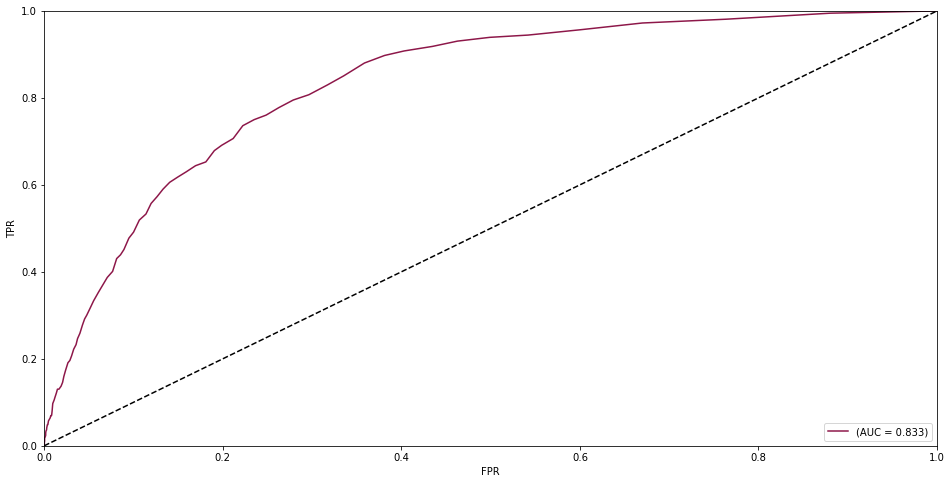

In [14]:
# Run this so your plots show properly
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 12
plt.figure(figsize=(16,8))
fpr_bal, tpr_bal, threshold = roc_curve(Y_test_bin, y_proba_rf_bin)
c = (np.random.rand(), np.random.rand(), np.random.rand())
roc_auc = auc(fpr_bal, tpr_bal)
plt.plot(fpr_bal, tpr_bal, color = c, label = '(AUC = %0.3f)' % roc_auc) 
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

In [15]:
print(pd.DataFrame(confusion_matrix(Y_test_bin, y_preds_rf_bin, normalize = 'true', labels = [0,1]), \
                   columns = ['0', '1'], index = ['0','1']))

          0         1
0  0.969349  0.030651
1  0.793403  0.206597


In [16]:
EV_binary(Y_test_bin, y_preds_rf_bin, V_tp = 0, V_tn = 0, C_fp = -0.1875, C_fn = -0.75)

-0.07717803030303032

In [155]:
corr_cols = list(X_train.columns)
corr_cols.append('Y_fire_class_size')
corr_cols.append('Y_bin')
X_train_corr = np.corrcoef(target_df[corr_cols].transpose())

In [156]:
print(X_train_corr.shape)
X_train_corr_df = pd.DataFrame(X_train_corr, columns = corr_cols, index = corr_cols)
X_train_corr_df.to_csv(os.path.join(data_dir, 'model_outputs/X_train_correlation_matrix.csv'))

(172, 172)


### Logistic Regression on the top 25 features from feature importances in random forest

#### Baseline Model - No Class Balancing

/Users/pedrogalarza/miniconda3/envs/geopandas_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
No handles with labels found to put in legend.


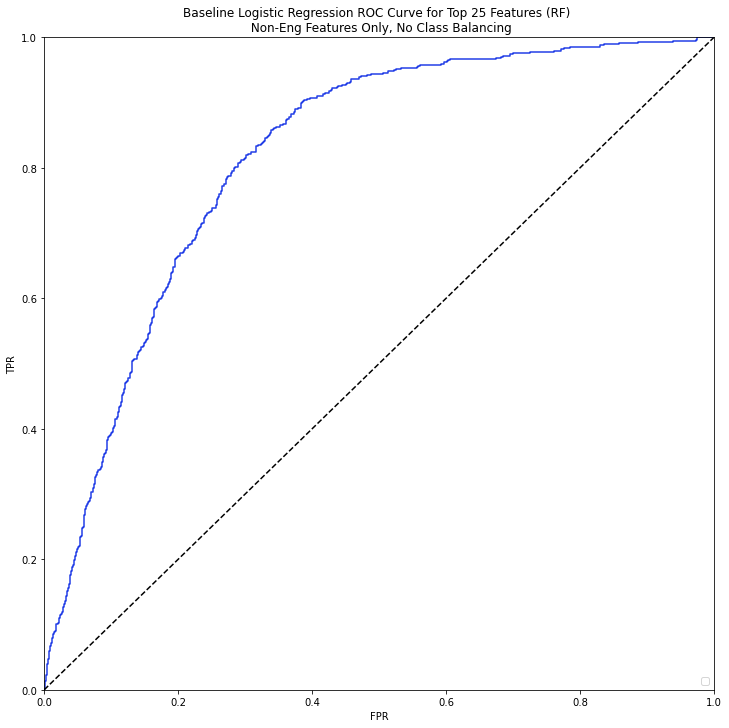

In [157]:
Base_LR = LogisticRegression().fit(X_train_LR[25], Y_train_bin)
Base_LR_score = Base_LR.predict_proba(X_test_LR[25])[:,1]
Base_LR_preds = Base_LR.predict(X_test_LR[25])
fpr, tpr, thresholds = roc_curve(Y_test_bin, Base_LR_score)
roc_auc = auc(fpr, tpr)

#chooses a random color for plotting
col = (np.random.rand(), np.random.rand(), np.random.rand())

#plot current model ROC curve
plt.plot(fpr, tpr, color = col) 
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Baseline Logistic Regression ROC Curve for Top 25 Features (RF) \n Non-Eng Features Only, No Class Balancing')
plt.legend(loc="lower right")

In [158]:
print(pd.DataFrame(confusion_matrix(Y_test_bin, Base_LR_preds, labels = [0,1],normalize = 'true'), \
                   columns = ['0', '1'], index = ['0','1']))

          0         1
0  0.999282  0.000718
1  0.996528  0.003472


In [159]:
EV_binary(Y_test_bin, Base_LR_preds, V_tp = 0, V_tn = 0, C_fp = -0.1875, C_fn = -0.75)

-0.09071180555555557

#### Baseline Model - with Class Balancing

/Users/pedrogalarza/miniconda3/envs/geopandas_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
No handles with labels found to put in legend.


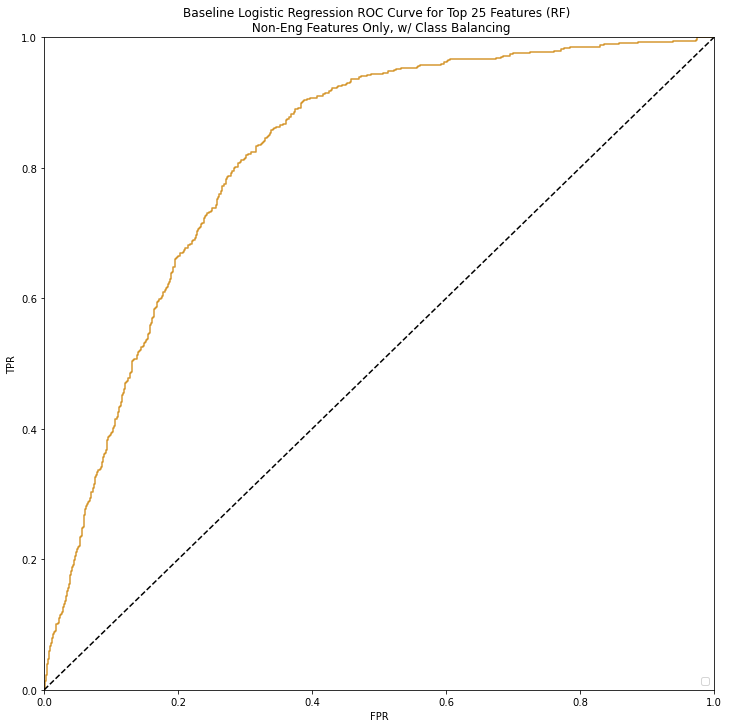

In [137]:
Base_weighted_LR = LogisticRegression(class_weight = 'balanced').fit(X_train_LR[25], Y_train_bin)
Base_weighted_LR_score = Base_weighted_LR.predict_proba(X_test_LR[25])[:,1]
Base_weighted_LR_preds = Base_weighted_LR.predict(X_test_LR[25])
fpr, tpr, thresholds = roc_curve(Y_test_bin, Base_LR_score)
roc_auc = auc(fpr, tpr)

#chooses a random color for plotting
col = (np.random.rand(), np.random.rand(), np.random.rand())

#plot current model ROC curve
plt.plot(fpr, tpr, color = col) 
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Baseline Logistic Regression ROC Curve for Top 25 Features (RF) \n Non-Eng Features Only, w/ Class Balancing')
plt.legend(loc="lower right")

In [136]:
print(pd.DataFrame(confusion_matrix(Y_test_bin, Base_weighted_LR_preds, labels = [0,1],normalize = 'true'), \
                   columns = ['0', '1'], index = ['0','1']))

          0         1
0  0.722701  0.277299
1  0.217014  0.782986


In [160]:
EV_binary(Y_test_bin, Base_weighted_LR_preds, V_tp = 0, V_tn = 0, C_fp = -0.1875, C_fn = -0.75)

-0.06541982323232323